## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.

Let's load the data:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, roc_auc_score
import xgboost as xgb

%matplotlib inline

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('../../data/AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)

* Fill NAs with 0
* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1

In [3]:
df.isna().sum()

neighbourhood_group               0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [4]:
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


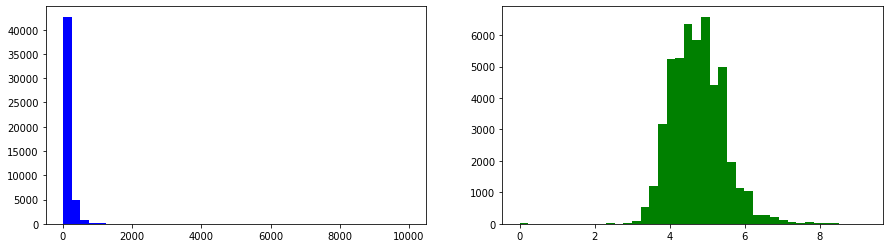

In [5]:
fig, ax = plt.subplots(1,2,figsize=(15,4))
ax[0].hist(df['price'], bins=40, color='blue', alpha=1);
ax[1].hist(np.log1p(df['price']), bins=40, color='green', alpha=1);

In [6]:
df['price'] = np.log1p(df['price'])

In [7]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)
y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values
del df_train['price']
del df_val['price']
del df_test['price']

In [8]:
print(df_train.shape[0], df_val.shape[0], df_test.shape[0])
print(y_train.shape[0], y_val.shape[0], y_test.shape[0])

29337 9779 9779
29337 9779 9779


Now, use `DictVectorizer` to turn train and validation into matrices:

In [9]:
train_dicts = df_train.fillna(0).to_dict(orient='records')
val_dicts = df_val.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`

In [10]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [11]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

Answer: room_type

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [12]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [13]:
y_pred = rf.predict(X_val)

In [14]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

0.4598535778342608

What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

Answer: 0.459

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset

In [15]:
n_est = np.linspace(10,200,20).astype(int)
res = {}
for n in n_est:
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    res[n] = rmse

In [16]:
res

{10: 0.4598535778342608,
 20: 0.44783122647617707,
 30: 0.4451200348449819,
 40: 0.44322540476599925,
 50: 0.4422309033499618,
 60: 0.4415347874157756,
 70: 0.4408665092520829,
 80: 0.44076264110112295,
 90: 0.4402436823066316,
 100: 0.439782812295518,
 110: 0.4393283276631756,
 120: 0.439140100985395,
 130: 0.4392600896545383,
 140: 0.4391068172724505,
 150: 0.4390987893907921,
 160: 0.43891283738859316,
 170: 0.43886569128153563,
 180: 0.4390536136991924,
 190: 0.4389458407581751,
 200: 0.4389432007046648}

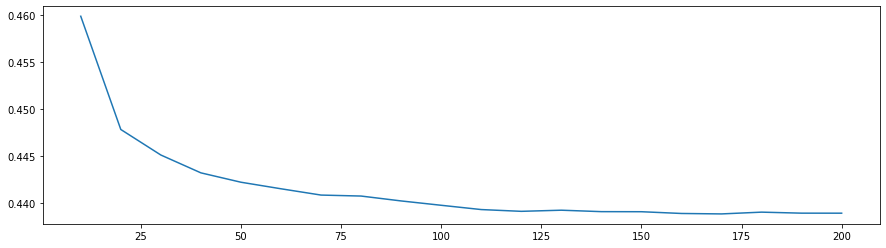

In [17]:
plt.figure(figsize=(15,4))
plt.plot(res.keys(), res.values())

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

Answer: 120

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [18]:
n_est = np.linspace(10,200,20).astype(int)
max_depth = [10,15,20,25]

res = {}
for n in n_est:
    for d in max_depth:
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        res[str(n)+"/"+str(d)] = rmse

What's the best `max_depth`:

* 10
* 15
* 20
* 25

Bonus question (not graded):

Will the answer be different if we change the seed for the model?

In [19]:
list(res.keys())[list(res.values()).index(min(res.values()))]

'170/15'

Answer: 15

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [20]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [21]:
importances = rf.feature_importances_
feature_names = list(dv.get_feature_names_out())

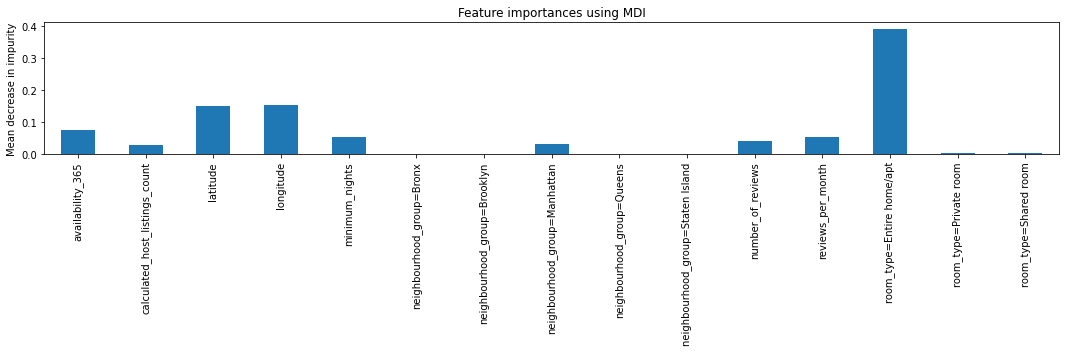

In [22]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(15,5))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

Answer: room_type=Entire home/apt

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [23]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

/mnt/d/python_environments/mlzoomcamp_linux/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [24]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [25]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    # 'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [26]:
s = output.stdout
print(s[-200:])

train-rmse:0.37668	val-rmse:0.43526
[85]	train-rmse:0.37259	val-rmse:0.43537
[90]	train-rmse:0.36998	val-rmse:0.43539
[95]	train-rmse:0.36742	val-rmse:0.43579
[99]	train-rmse:0.36478	val-rmse:0.43621



In [27]:
y_pred = model.predict(dval)
print(np.sqrt(mean_squared_error(y_val, y_pred)))

0.43621034591295677


Now change `eta` first to `0.1` and then to `0.01`

In [28]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    # 'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [29]:
s = output.stdout
print(s[-200:])

train-rmse:0.40747	val-rmse:0.43306
[85]	train-rmse:0.40626	val-rmse:0.43299
[90]	train-rmse:0.40478	val-rmse:0.43280
[95]	train-rmse:0.40406	val-rmse:0.43272
[99]	train-rmse:0.40277	val-rmse:0.43250



In [30]:
y_pred = model.predict(dval)
print(np.sqrt(mean_squared_error(y_val, y_pred)))

0.43249655247991464


In [31]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    # 'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [32]:
s = output.stdout
print(s[-200:])

train-rmse:1.95022	val-rmse:1.94827
[85]	train-rmse:1.86015	val-rmse:1.85833
[90]	train-rmse:1.77472	val-rmse:1.77302
[95]	train-rmse:1.69373	val-rmse:1.69214
[99]	train-rmse:1.63198	val-rmse:1.63045



In [33]:
y_pred = model.predict(dval)
print(np.sqrt(mean_squared_error(y_val, y_pred)))

1.630452438951798


What's the best eta?

* 0.3
* 0.1
* 0.01

## Submit the results


Submit your results here: https://forms.gle/wQgFkYE6CtdDed4w8

It's possible that your answers won't match exactly. If it's the case, select the closest one.


## Deadline


The deadline for submitting is 20 October 2021, 17:00 CET (Wednesday). After that, the form will be closed.

